In [1]:
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import pathlib
import pandas as pd
from PIL import Image
import json
from tqdm.notebook import tqdm

Using TensorFlow backend.


In [2]:
train_images_path = '/mnt/hdd/gbowlds/images/100k/train'
val_images_path = '/mnt/hdd/gbowlds/images/100k/val'
lbls_path = pathlib.Path('/mnt/hdd/gbowlds/nclabels/labels/bdd100k_nclabels_images_train.json')
val_lbls_path = pathlib.Path('/mnt/hdd/gbowlds/nclabels/labels/bdd100k_nclabels_images_val.json')
train_images = []
train_labels = []
val_images = []
val_labels = []
c_count = 0
o_count = 0
p_count = 0
r_count = 0
s_count = 0
check = 1001

In [3]:
def make_train_lists(sample: str):
    image_path = pathlib.Path(train_images_path + '/' + sample['name'])
    data = np.array(Image.open(image_path).resize((224,224)))
    weather = sample['attributes']['weather']
    tod = sample['attributes']['timeofday']
    
    if tod == 'daytime' and weather != 'foggy' and weather != 'undefined':
        if weather == 'clear':
            global c_count
            c_count = c_count+1
            if c_count < check:
                w_data = 0
            else:
                w_data = 5
        elif weather == 'overcast':
            global o_count
            o_count = o_count+1
            if o_count < check:
                w_data = 1
            else:
                w_data = 5
        elif weather == 'partly cloudy':
            global p_count
            p_count = p_count+1
            if p_count < check:
                w_data = 2
            else:
                w_data = 5
            
        elif weather == 'rainy':
            global r_count
            r_count  = r_count+1
            if r_count < check:
                w_data = 3
            else:
                w_data = 5
            
        elif weather == 'snowy':
            global s_count
            s_count = s_count + 1
            if s_count < check:
                w_data = 4
            else:
                w_data = 5
            
            
        if w_data != 5:
            train_images.append(data)
            train_labels.append(w_data)

In [4]:
def make_val_lists(sample: str):
    image_path = pathlib.Path(val_images_path + '/' + sample['name'])
    data = np.array(Image.open(image_path).resize((224,224)))
    weather = sample['attributes']['weather']
    tod = sample['attributes']['timeofday']
    
    if tod == 'daytime' and weather != 'foggy' and weather != 'undefined':
        if weather == 'clear':
            w_data = 0
        elif weather == 'overcast':
            w_data = 1
        elif weather == 'partly cloudy':
            w_data = 2
        elif weather == 'rainy':
            w_data = 3
        elif weather == 'snowy':
            w_data = 4
        val_images.append(data)
        val_labels.append(w_data)

In [5]:
with open(lbls_path) as lbls_file:
        samples = json.load(lbls_file)
        random.shuffle(samples)
    
        for sample in tqdm(samples):
            if len(train_images) < 5000:
                make_train_lists(sample)
train_images = np.asarray(train_images)

In [6]:
print(train_labels.count(0))
print(train_labels.count(1))
print(train_labels.count(2))
print(train_labels.count(3))
print(train_labels.count(4))

1000
1000
1000
1000
1000


In [7]:
with open (val_lbls_path) as lbls_file:
        samples = json.load(lbls_file)
        random.shuffle(samples)
    
        for sample in tqdm(samples):
            if len(val_images) < 1000:
                make_val_lists(sample)
                
val_images = np.array(val_images)

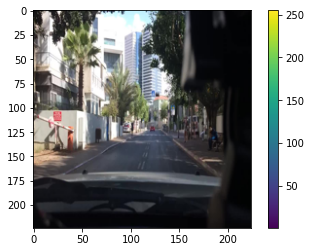

In [8]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [9]:
from keras import applications
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
input_shape= (224,224,3)

In [58]:
cnn3 = Sequential()
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn3.add(MaxPooling2D((2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn3.add(Dropout(0.4))

cnn3.add(Flatten())

cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.3))
cnn3.add(Dense(5, activation='softmax'))

In [38]:
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

94658560/94653016 [==============================] - 1s 0us/step


In [39]:
from keras.optimizers import Adam
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x) 
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)
adam = Adam(lr=0.0001)
resnet50 = Model(inputs=base_model.input, outputs=predictions)
resnet50.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
print(len(train_images))
print(len(train_labels))

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

5000
5000


In [11]:
train_labels = keras.utils.to_categorical(train_labels, 5, dtype='float32')
val_labels = keras.utils.to_categorical(val_labels, 5, dtype='float32')
train_generator = train_datagen.flow(train_images, train_labels, batch_size=3)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=3)

In [25]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/mnt/hdd/gbowlds/weather_model_cnn3.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [21]:
history = resnet50.fit_generator(train_generator,
                             steps_per_epoch = 1000,
                             epochs = 10,
                             validation_data = val_generator,
                             validation_steps = 1000)
#saved: loss: accuracy: 0.944 val_accuracy: 0.66
#last epoch: loss: 1.2286 - accuracy: 0.4773 - val_loss: 1.1914 - val_accuracy: 0.4840

Epoch 1/10
1000/1000 [==============================] - 671s 671ms/step - loss: 0.0930 - accuracy: 0.9683 - val_loss: 0.0037 - val_accuracy: 0.6666
Epoch 2/10
1000/1000 [==============================] - 665s 665ms/step - loss: 0.1072 - accuracy: 0.9580 - val_loss: 0.0622 - val_accuracy: 0.6273
Epoch 3/10
1000/1000 [==============================] - 665s 665ms/step - loss: 0.1598 - accuracy: 0.9473 - val_loss: 0.0897 - val_accuracy: 0.6603
Epoch 4/10
1000/1000 [==============================] - 664s 664ms/step - loss: 0.1430 - accuracy: 0.9500 - val_loss: 1.9791 - val_accuracy: 0.6420
Epoch 5/10
1000/1000 [==============================] - 665s 665ms/step - loss: 0.1379 - accuracy: 0.9510 - val_loss: 6.3095 - val_accuracy: 0.6540
Epoch 6/10
1000/1000 [==============================] - 665s 665ms/step - loss: 0.1087 - accuracy: 0.9637 - val_loss: 0.0123 - val_accuracy: 0.6032
Epoch 7/10
1000/1000 [==============================] - 665s 665ms/step - loss: 0.1510 - accuracy: 0.9530 - val_

In [22]:
#model.save("/mnt/hdd/gbowlds/weather_model_cnn3.h5")
resnet50.save("/mnt/hdd/gbowlds/weather_model_resnet_3.h5")

In [23]:
#model = keras.models.load_model('/mnt/hdd/gbowlds/weather_model_cnn3.h5')
resnet50 = keras.models.load_model('/mnt/hdd/gbowlds/weather_model_resnet_2.h5')

In [24]:
results = resnet50.evaluate_generator(val_generator, 100)
print(results)

[0.08493191003799438, 0.6966666579246521]


In [46]:
test_path = pathlib.Path('/mnt/hdd/gbowlds/images/100k/test/cae4f10f-e5906613.jpg')
y = np.array(Image.open(test_path).resize((224,224))) / 255
y = np.expand_dims(y, axis=0)
classes = resnet50.predict(y)
print(classes)

[[0.21880321 0.18096201 0.19123694 0.227722   0.18127589]]


In [143]:
print(train_labels[:10])

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
